In [50]:
print("Testing Connection \
   \nUse GPU")

Testing Connection    
Use GPU


# Enviroment Setup 

### Connect to Azure ML workspace

In [25]:
import pandas as pd

from azureml.core import Experiment, Run, Workspace
import azureml.core

# Check core SDK version number
print("SDK version:", azureml.core.VERSION)

ws = Workspace.from_config()

# choose a name for experiment
experiment_name = 'scriptsclassification'

experiment=Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T


SDK version: 1.19.0


,
Subscription ID,6a0ec27b-1203-46fe-ade0-8c3003d5e4bc
Workspace,MLServiceWrokspace
Resource Group,MLServiceWrokspace
Location,northeurope
Experiment Name,scriptsclassification


### General imports

In [26]:
import numpy as np
import pandas as pd
import csv
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

In [51]:
data = {'Label':[1,2,3,4,5],
        'Type':["RomCom","Horror","Heist","Comedy","Sci-Fi"]}

dftype = pd.DataFrame (data, columns = ['Label','Type'])

dftype

,Label,Type
0,1,RomCom
1,2,Horror
2,3,Heist
3,4,Comedy
4,5,Sci-Fi


### Load scripts for testing and training data

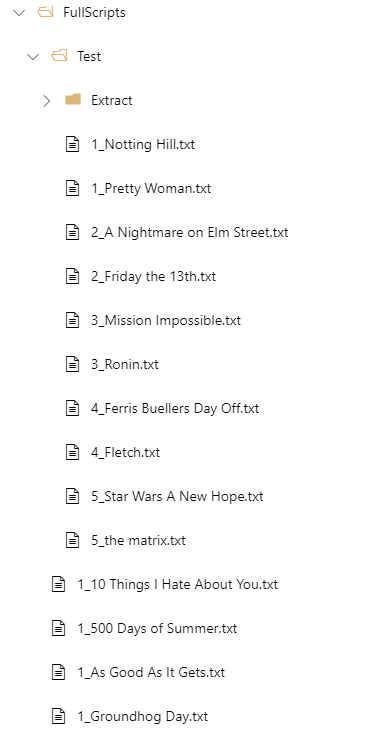

In [28]:
#Create a function to save on code
def getfilelistDF(location):
    allscripts = os.listdir(location)
    allscripts
    filename = ''
    dfscript = pd.DataFrame(columns = ['Label', 'Text', 'filename'])

    for script in allscripts:
        if script[-4:] == '.txt':
            filename = script
            raw_text = open(location + filename, 'r', encoding='utf-8').read()
            #raw_text = raw_text.lower()
            dfscript = dfscript.append({'Label':filename[0], 'Text':raw_text, 'filename':filename}, ignore_index=True)
    return dfscript

In [29]:
#Get training data from 2 directories
dfscript1 = getfilelistDF("./Scripts/")
dfscript2 = getfilelistDF("./FullScripts/")

#Concat and reindex
dfscript = pd.concat([dfscript1, dfscript2])
dfscript = dfscript.reset_index(drop=True)

#Get the testing data
dfscriptTesting =  getfilelistDF("./FullScripts/Test/")


# Word Embeddings

<p><b>Word embedding</b> is any of a set of language modeling and feature learning techniques in natural language processing (NLP) where words or phrases from the vocabulary are mapped to vectors of real numbers. Conceptually it involves a mathematical embedding from a space with many dimensions per word to a continuous vector space with a much lower dimension.</p>
<p>(wikipedia)</p>

### CountVectorizer / One-Hot Encoding

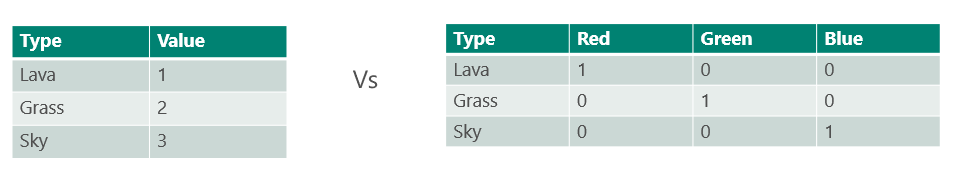

In [30]:
#Run a CountVectorizer to get the frequency of words in the document
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
     'Microsoft has a great public cloud called Azure',
     'Azure is a cloud technology',
     'You can run Machine Learning on Azure. This is Machine Learning',
     'Isnt Azure great']
vectorizer = CountVectorizer()
X_train_Counts = vectorizer.fit_transform(corpus)
print(pd.DataFrame(corpus))
print("\nVectorizer.get_feature_names")
print(vectorizer.get_feature_names())
print("\nHow many of each ords we have in each document")
df = pd.DataFrame(X_train_Counts.toarray())
df.columns = vectorizer.get_feature_names()
df

                                                                 0
0  Microsoft has a great public cloud called Azure                
1  Azure is a cloud technology                                    
2  You can run Machine Learning on Azure. This is Machine Learning
3  Isnt Azure great                                               

Vectorizer.get_feature_names
['azure', 'called', 'can', 'cloud', 'great', 'has', 'is', 'isnt', 'learning', 'machine', 'microsoft', 'on', 'public', 'run', 'technology', 'this', 'you']

How many of each ords we have in each document


,azure,called,can,cloud,great,has,is,isnt,learning,machine,microsoft,on,public,run,technology,this,you
0,1,1,0,1,1,1,0,0,0,0,1,0,1,0,0,0,0
1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
2,1,0,1,0,0,0,1,0,2,2,0,1,0,1,0,1,1
3,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


... but words do not understand relationships or simmilarity 

### Term-frequency times inverse document-frequency (tf-idf)

<p>How relevant a term is in a document</p>
<p>Log(total number of documents / total number of docs with the word in it)</p>
<p>In our example 'first' is only in the first document so is more imortant to that document. <br>
'the' is in multiple documents so is not as important to that first document</p>

                                                                 0
0  Microsoft has a great public cloud called Azure                
1  Azure is a cloud technology                                    
2  You can run Machine Learning on Azure. This is Machine Learning
3  Isnt Azure great                                               


,azure,called,can,cloud,great,has,is,isnt,learning,machine,microsoft,on,public,run,technology,this,you
sentence 1,0.222201,0.425802,0.00000,0.335707,0.335707,0.425802,0.000000,0.000000,0.000000,0.000000,0.425802,0.00000,0.425802,0.00000,0.000000,0.00000,0.00000
sentence 2,0.329023,0.000000,0.00000,0.497096,0.000000,0.000000,0.497096,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.630504,0.00000,0.00000
sentence 3,0.139999,0.000000,0.26828,0.000000,0.000000,0.000000,0.211515,0.000000,0.536559,0.536559,0.000000,0.26828,0.000000,0.26828,0.000000,0.26828,0.26828
sentence 4,0.379192,0.000000,0.00000,0.000000,0.572892,0.000000,0.000000,0.726641,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000


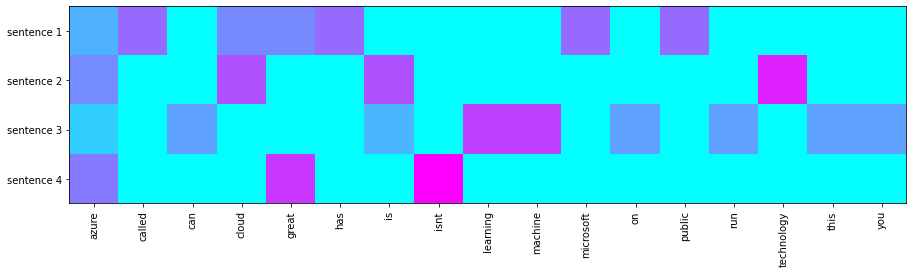

In [31]:
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
vectorized = tfidf_transformer.fit_transform(X_train_Counts)

print(pd.DataFrame(corpus))

tfidfdf = pd.DataFrame(vectorized.toarray(), 
             index=['sentence '+str(i) 
                    for i in range(1, 1+len(corpus))],
             columns=vectorizer.get_feature_names())

plt.figure(figsize=(15,10))
plt.xticks(ticks=np.arange(len(tfidfdf.columns)),labels=tfidfdf.columns,rotation=90)
plt.yticks(ticks=np.arange(len(tfidfdf.index)),labels=tfidfdf.index)
plt.imshow(tfidfdf, cmap='cool',interpolation="nearest")

tfidfdf

# Classic ML training

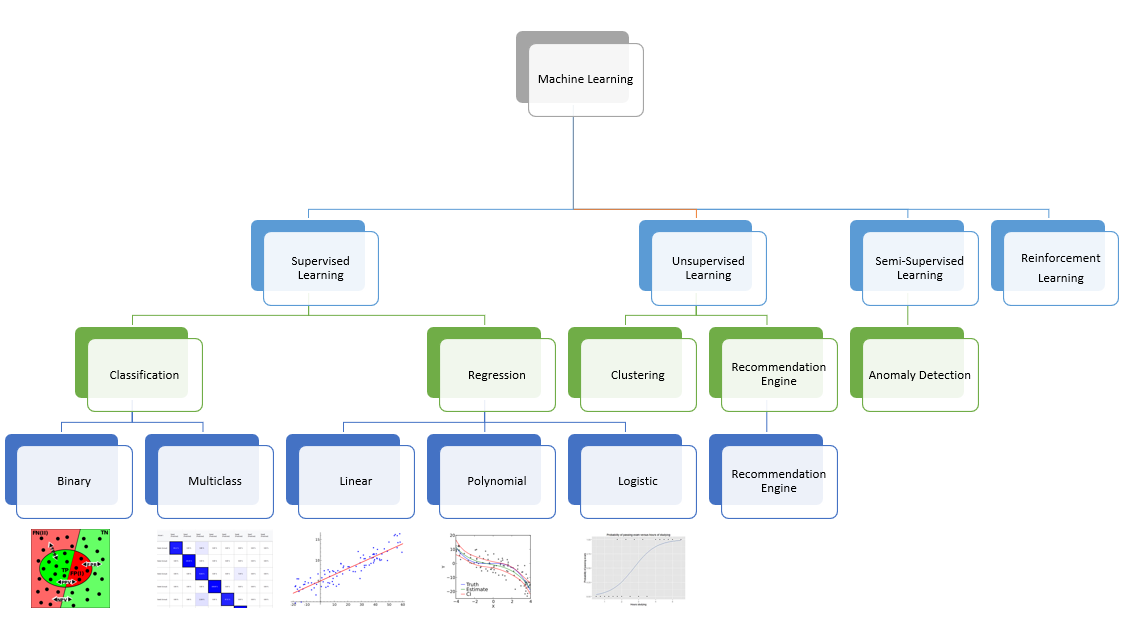

### Multinomial Naive Bayes classifier

Multinomial/polynomial = consisting of several terms

In [32]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer

#Count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(dfscript['Text'])
X_train_counts.shape

#Tfidf
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print(X_train_tfidf.shape)

#Train a model
clf = MultinomialNB().fit(X_train_tfidf, dfscript['Label'])

#Run predictions on the original data
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer

count_vect = CountVectorizer()
X_test_counts = count_vect.fit_transform(dfscript['Text'])

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
print(X_test_tfidf.shape)

predicted = clf.predict(X_test_tfidf)
print("Accuracy: " + str(np.mean(predicted == dfscript['Label'])))


(139, 45902)
(139, 45902)
Accuracy: 0.7913669064748201


### Construct a training pipeline

accuracy training data = 0.7913669064748201

accuracy testing data = 0.2

results: ['5' '5' '5' '5' '5' '5' '5' '5' '5' '5']



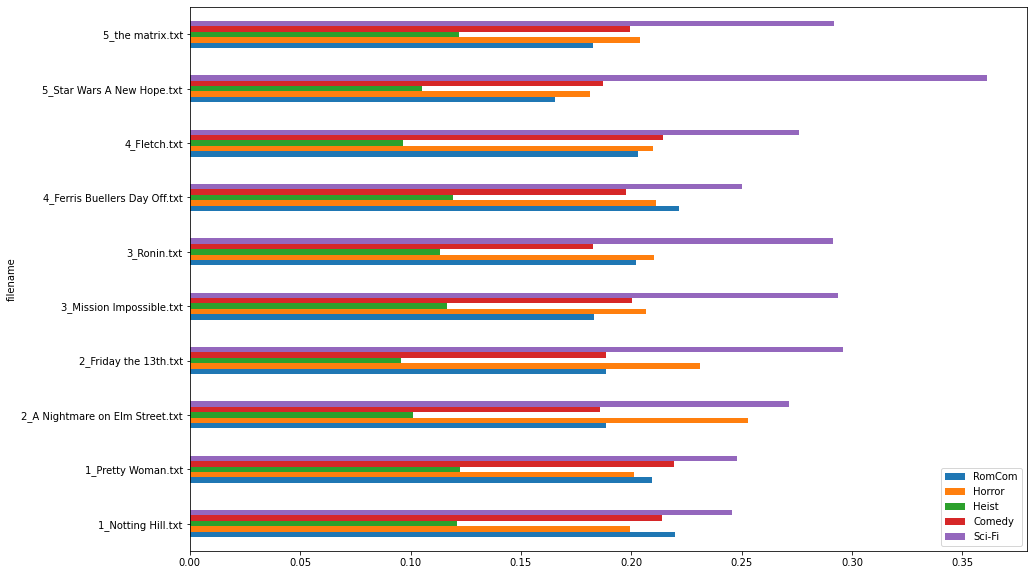

,RomCom,Horror,Heist,Comedy,Sci-Fi,filename
0,0.219863,0.199351,0.121247,0.214075,0.245464,1_Notting Hill.txt
1,0.209278,0.201110,0.122398,0.219325,0.247889,1_Pretty Woman.txt
2,0.188447,0.253063,0.101244,0.185708,0.271538,2_A Nightmare on Elm Street.txt
3,0.188377,0.231171,0.095765,0.188727,0.295959,2_Friday the 13th.txt
4,0.182995,0.206739,0.116505,0.200296,0.293465,3_Mission Impossible.txt
5,0.202282,0.210186,0.113270,0.182669,0.291592,3_Ronin.txt
6,0.221673,0.211249,0.119205,0.197562,0.250311,4_Ferris Buellers Day Off.txt
7,0.203185,0.209669,0.096477,0.214514,0.276155,4_Fletch.txt
8,0.165383,0.181237,0.105152,0.187099,0.361129,5_Star Wars A New Hope.txt
9,0.182555,0.204088,0.121884,0.199458,0.292015,5_the matrix.txt


In [33]:
#Create an experiment
experiment = Experiment(workspace=ws, name=experiment_name)
#Begin logging
run = experiment.start_logging(snapshot_directory=None)
#snapshot_directory=None = We have alot of training data so do not snapshot the folder to save time and space

#Tag in Azure
run.tag("Description","MultinomialNB")


#MultinomialNB = Naive Bayes classifier for multinomial models
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB())])

text_clf = text_clf.fit(dfscript['Text'], dfscript['Label'])

predicted = text_clf.predict(dfscript['Text'])

print('accuracy training data = ' + str(np.mean(text_clf.predict(dfscript['Text']) == dfscript['Label'])))
run.log('accuracy training data', np.mean(text_clf.predict(dfscript['Text']) == dfscript['Label']))
print('\r')
print('accuracy testing data = ' + str(np.mean(text_clf.predict(dfscriptTesting['Text']) == dfscriptTesting['Label'])))
run.log('accuracy testing data', np.mean(text_clf.predict(dfscriptTesting['Text']) == dfscriptTesting['Label']))
print('\r')
print('results: ' + str(text_clf.predict(dfscriptTesting['Text'])))
run.log('results', text_clf.predict(dfscriptTesting['Text']))
print('\r')
dfres = pd.DataFrame(text_clf.predict_proba(dfscriptTesting['Text'])).rename(columns = {0:'RomCom', 1:'Horror', 2:"Heist" , 3: "Comedy", 4: "Sci-Fi"})
dfres['filename'] = dfscriptTesting['filename']

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
dfres.plot.barh(x='filename',figsize=(15,10), sort_columns=True)
run.log_image("results graph", path=None, plot=plt)
plt.show()

run.complete()

pd.DataFrame(dfres)


# Stop Words

### Word encodings per film

In [53]:
#Show top words for each film
script = int(33)

dfwordfreq = pd.DataFrame(pd.DataFrame(X_test_tfidf.toarray(), 
             index=[str(i) 
                    for i in range(0, 0+len(dfscript))],
             columns=count_vect.get_feature_names()).iloc[script])

print(dfscript['filename'][script])
dfwordfreq.sort_values(by=[str(script)], ascending=False).head(15)


4_babe.txt


,33
pig,0.50
sheep,0.36
hoggett,0.33
maa,0.26
rex,0.18
babe,0.16
woof,0.14
pigs,0.14
wolf,0.13
ewe,0.13


### Remove stop words (words that have no importance significance eg 'and', 'in', 'at' etc etc)

In [35]:
count_vect = CountVectorizer(stop_words='english')
X_test_counts = count_vect.fit_transform(dfscript['Text'])

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)

script = int(33)

dfwordfreq = pd.DataFrame(pd.DataFrame(X_test_tfidf.toarray(), 
             index=[str(i) 
                    for i in range(0, 0+len(dfscript))],
             columns=count_vect.get_feature_names()).iloc[script])

print(dfscript['filename'][script])

dfwordfreq.sort_values(by=[str(script)], ascending=False).head(15)


4_babe.txt


,33
pig,0.497443
sheep,0.356172
hoggett,0.329529
maa,0.263623
rex,0.184292
babe,0.155009
woof,0.141440
pigs,0.137934
wolf,0.133901
ewe,0.131812


accuracy training data = 1.0

accuracy testing data = 0.5

results: ['1' '4' '2' '2' '5' '5' '1' '1' '5' '5']



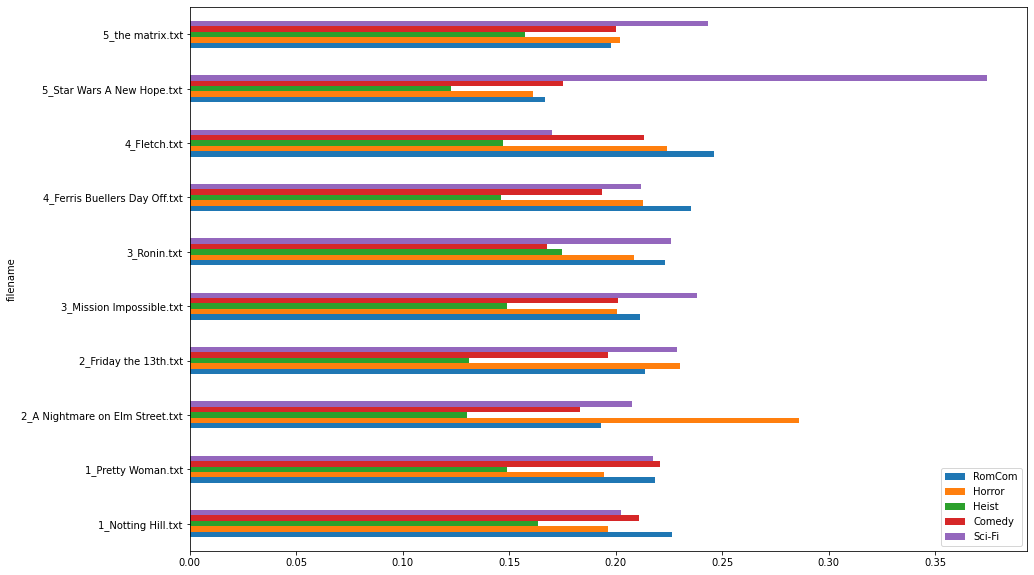

CPU times: user 8.72 s, sys: 141 ms, total: 8.86 s
Wall time: 17.5 s


,RomCom,Horror,Heist,Comedy,Sci-Fi,filename
0,0.226523,0.196540,0.163596,0.210827,0.202515,1_Notting Hill.txt
1,0.218339,0.194312,0.149007,0.220772,0.217570,1_Pretty Woman.txt
2,0.192945,0.285840,0.130356,0.183313,0.207546,2_A Nightmare on Elm Street.txt
3,0.213930,0.230259,0.131011,0.196208,0.228591,2_Friday the 13th.txt
4,0.211539,0.200416,0.149132,0.200842,0.238071,3_Mission Impossible.txt
5,0.223015,0.208415,0.174878,0.167868,0.225824,3_Ronin.txt
6,0.235454,0.212846,0.146226,0.193696,0.211778,4_Ferris Buellers Day Off.txt
7,0.246091,0.224115,0.146851,0.213104,0.169838,4_Fletch.txt
8,0.166842,0.161327,0.122443,0.175090,0.374298,5_Star Wars A New Hope.txt
9,0.197565,0.201959,0.157313,0.199953,0.243210,5_the matrix.txt


In [36]:
%%time
#MultinomialNB = Naive Bayes classifier for multinomial models with stop words

experiment = Experiment(workspace=ws, name=experiment_name)
run = experiment.start_logging(snapshot_directory=None)

run.tag("Description","MultinomialNB with stop words")

from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB())])

text_clf = text_clf.fit(dfscript['Text'], dfscript['Label'])

predicted = text_clf.predict(dfscript['Text'])

print('accuracy training data = ' + str(np.mean(text_clf.predict(dfscript['Text']) == dfscript['Label'])))
run.log('accuracy training data', np.mean(text_clf.predict(dfscript['Text']) == dfscript['Label']))
print('\r')
print('accuracy testing data = ' + str(np.mean(text_clf.predict(dfscriptTesting['Text']) == dfscriptTesting['Label'])))
run.log('accuracy testing data', np.mean(text_clf.predict(dfscriptTesting['Text']) == dfscriptTesting['Label']))
print('\r')
print('results: ' + str(text_clf.predict(dfscriptTesting['Text'])))
run.log('results', text_clf.predict(dfscriptTesting['Text']))
print('\r')
dfres = pd.DataFrame(text_clf.predict_proba(dfscriptTesting['Text'])).rename(columns = {0:'RomCom', 1:'Horror', 2:"Heist" , 3: "Comedy", 4: "Sci-Fi"})
dfres['filename'] = dfscriptTesting['filename']

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
dfres.plot.barh(x='filename',figsize=(15,10), sort_columns=True)
run.log_image("results graph", path=None, plot=plt)
plt.show()

run.complete()

pd.DataFrame(dfres)

## What is Overfitting?

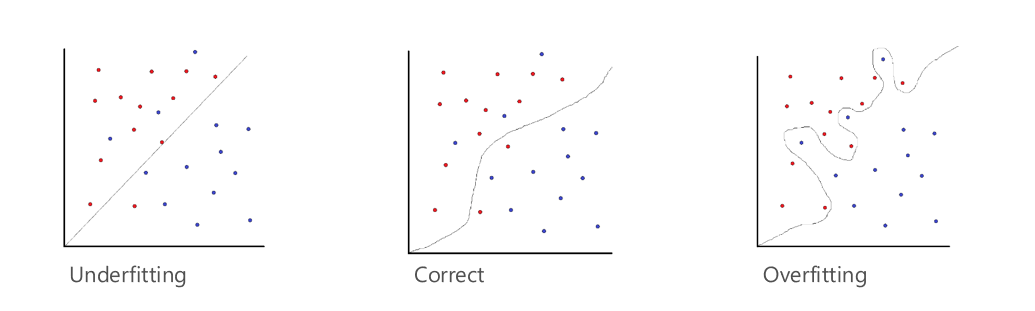

### RandomForest

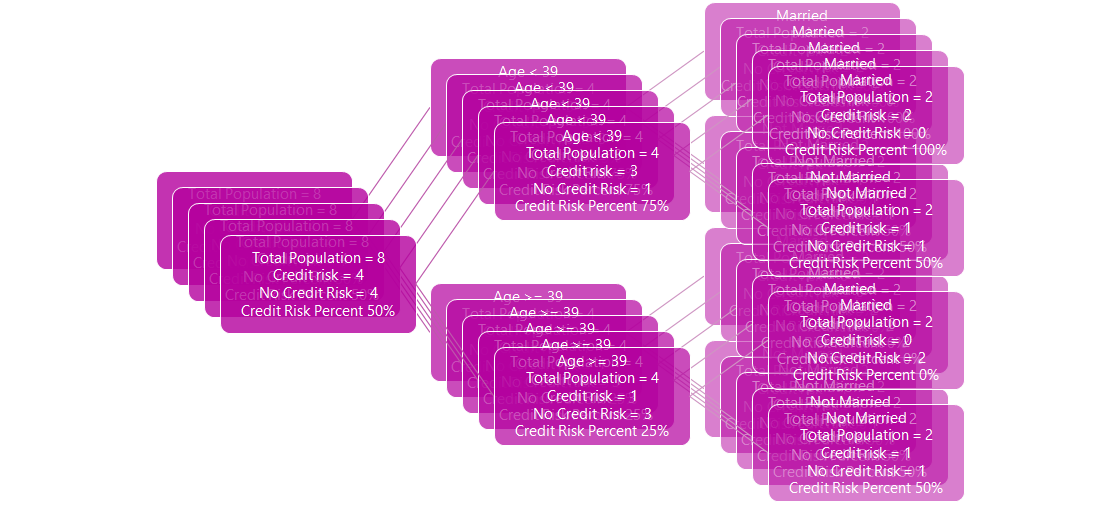

accuracy training data = 1.0

accuracy testing data = 0.5

results: ['1' '4' '5' '2' '5' '5' '4' '3' '5' '5']



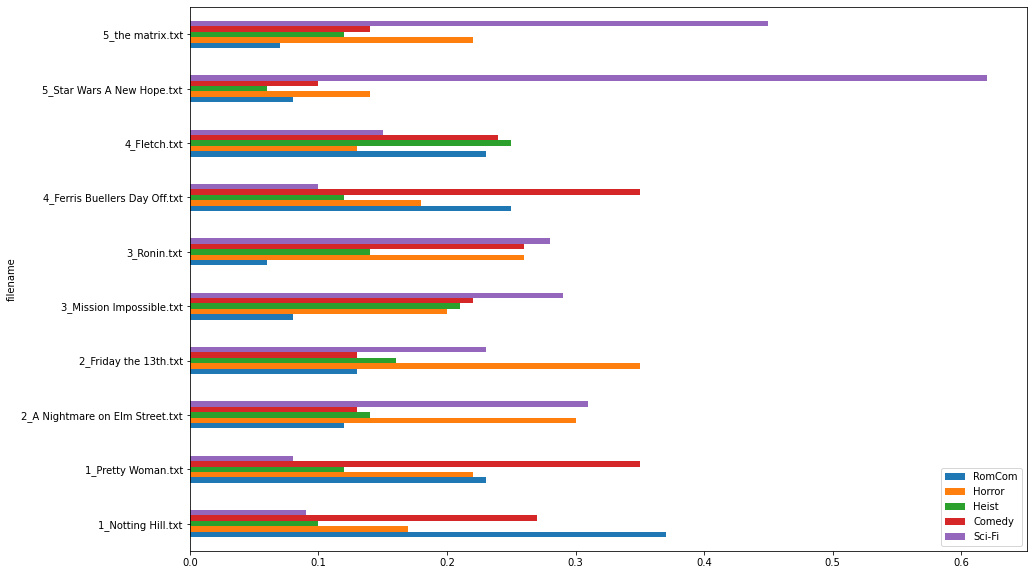

CPU times: user 9.74 s, sys: 160 ms, total: 9.9 s
Wall time: 17.7 s


,RomCom,Horror,Heist,Comedy,Sci-Fi,filename
0,0.37,0.17,0.10,0.27,0.09,1_Notting Hill.txt
1,0.23,0.22,0.12,0.35,0.08,1_Pretty Woman.txt
2,0.12,0.30,0.14,0.13,0.31,2_A Nightmare on Elm Street.txt
3,0.13,0.35,0.16,0.13,0.23,2_Friday the 13th.txt
4,0.08,0.20,0.21,0.22,0.29,3_Mission Impossible.txt
5,0.06,0.26,0.14,0.26,0.28,3_Ronin.txt
6,0.25,0.18,0.12,0.35,0.10,4_Ferris Buellers Day Off.txt
7,0.23,0.13,0.25,0.24,0.15,4_Fletch.txt
8,0.08,0.14,0.06,0.10,0.62,5_Star Wars A New Hope.txt
9,0.07,0.22,0.12,0.14,0.45,5_the matrix.txt


In [37]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

experiment = Experiment(workspace=ws, name=experiment_name)
run = experiment.start_logging(snapshot_directory=None)

run.tag("Description","RandomForestClassifier with stop words")

text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                      ('tfidf', TfidfTransformer()),
                      ('clf', RandomForestClassifier())])

text_clf = text_clf.fit(dfscript['Text'], dfscript['Label'])

predicted = text_clf.predict(dfscript['Text'])

print('accuracy training data = ' + str(np.mean(text_clf.predict(dfscript['Text']) == dfscript['Label'])))
run.log('accuracy training data', np.mean(text_clf.predict(dfscript['Text']) == dfscript['Label']))
print('\r')
print('accuracy testing data = ' + str(np.mean(text_clf.predict(dfscriptTesting['Text']) == dfscriptTesting['Label'])))
run.log('accuracy testing data', np.mean(text_clf.predict(dfscriptTesting['Text']) == dfscriptTesting['Label']))
print('\r')
print('results: ' + str(text_clf.predict(dfscriptTesting['Text'])))
run.log('results', text_clf.predict(dfscriptTesting['Text']))
print('\r')
dfres = pd.DataFrame(text_clf.predict_proba(dfscriptTesting['Text'])).rename(columns = {0:'RomCom', 1:'Horror', 2:"Heist" , 3: "Comedy", 4: "Sci-Fi"})
dfres['filename'] = dfscriptTesting['filename']

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
dfres.plot.barh(x='filename',figsize=(15,10), sort_columns=True)
run.log_image("results graph", path=None, plot=plt)
plt.show()

run.complete()

pd.DataFrame(dfres)

## Neural Network

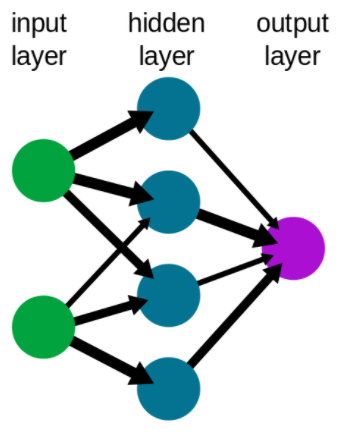

accuracy training data = 1.0

accuracy testing data = 0.6

results: ['1' '4' '2' '2' '5' '3' '1' '1' '5' '5']



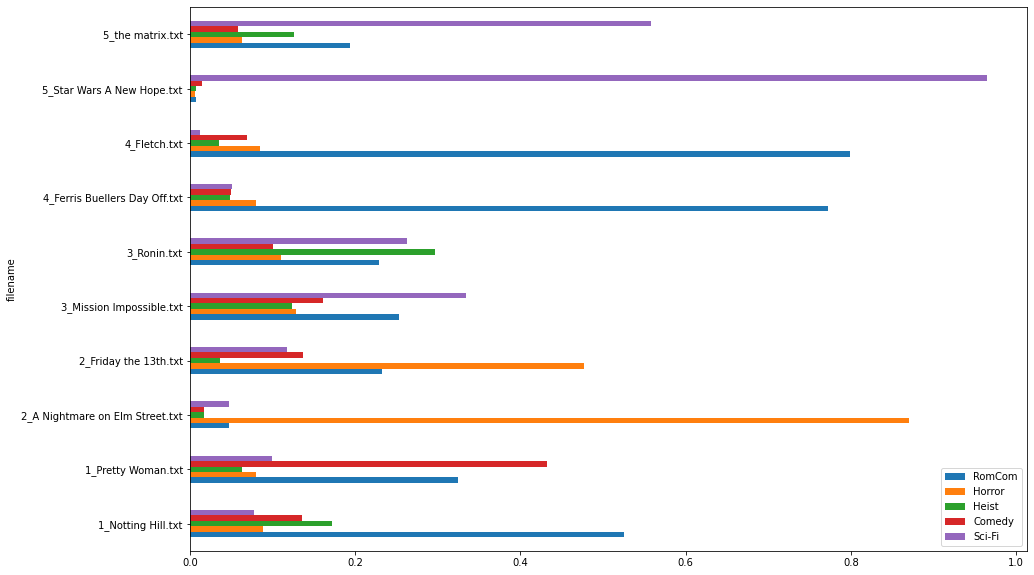

CPU times: user 1min 14s, sys: 1min 14s, total: 2min 29s
Wall time: 1min 6s


,RomCom,Horror,Heist,Comedy,Sci-Fi,filename
0,0.526004,0.088205,0.172428,0.136117,0.077247,1_Notting Hill.txt
1,0.324595,0.079513,0.063666,0.432895,0.099331,1_Pretty Woman.txt
2,0.047865,0.870597,0.017345,0.017123,0.047070,2_A Nightmare on Elm Street.txt
3,0.232003,0.477380,0.036221,0.137020,0.117377,2_Friday the 13th.txt
4,0.252739,0.128527,0.123473,0.161078,0.334182,3_Mission Impossible.txt
5,0.229398,0.109978,0.296887,0.101222,0.262515,3_Ronin.txt
6,0.772268,0.079596,0.048025,0.049428,0.050684,4_Ferris Buellers Day Off.txt
7,0.798988,0.084426,0.035488,0.069062,0.012036,4_Fletch.txt
8,0.007130,0.005891,0.007297,0.014826,0.964855,5_Star Wars A New Hope.txt
9,0.193896,0.062555,0.126171,0.058614,0.558764,5_the matrix.txt


In [38]:
%%time
#Neural Network
from sklearn.neural_network import MLPClassifier

experiment = Experiment(workspace=ws, name=experiment_name)
run = experiment.start_logging(snapshot_directory=None)

run.tag("Description","MLPClassifier with stop words")

from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MLPClassifier())])

text_clf = text_clf.fit(dfscript['Text'], dfscript['Label'])

predicted = text_clf.predict(dfscript['Text'])

print('accuracy training data = ' + str(np.mean(text_clf.predict(dfscript['Text']) == dfscript['Label'])))
run.log('accuracy training data', np.mean(text_clf.predict(dfscript['Text']) == dfscript['Label']))
print('\r')
print('accuracy testing data = ' + str(np.mean(text_clf.predict(dfscriptTesting['Text']) == dfscriptTesting['Label'])))
run.log('accuracy testing data', np.mean(text_clf.predict(dfscriptTesting['Text']) == dfscriptTesting['Label']))
print('\r')
print('results: ' + str(text_clf.predict(dfscriptTesting['Text'])))
run.log('results', text_clf.predict(dfscriptTesting['Text']))
print('\r')
dfres = pd.DataFrame(text_clf.predict_proba(dfscriptTesting['Text'])).rename(columns = {0:'RomCom', 1:'Horror', 2:"Heist" , 3: "Comedy", 4: "Sci-Fi"})
dfres['filename'] = dfscriptTesting['filename']

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
dfres.plot.barh(x='filename',figsize=(15,10), sort_columns=True)
run.log_image("results graph", path=None, plot=plt)
plt.show()

run.complete()

pd.DataFrame(dfres)


### SVM - Support Vector Machine

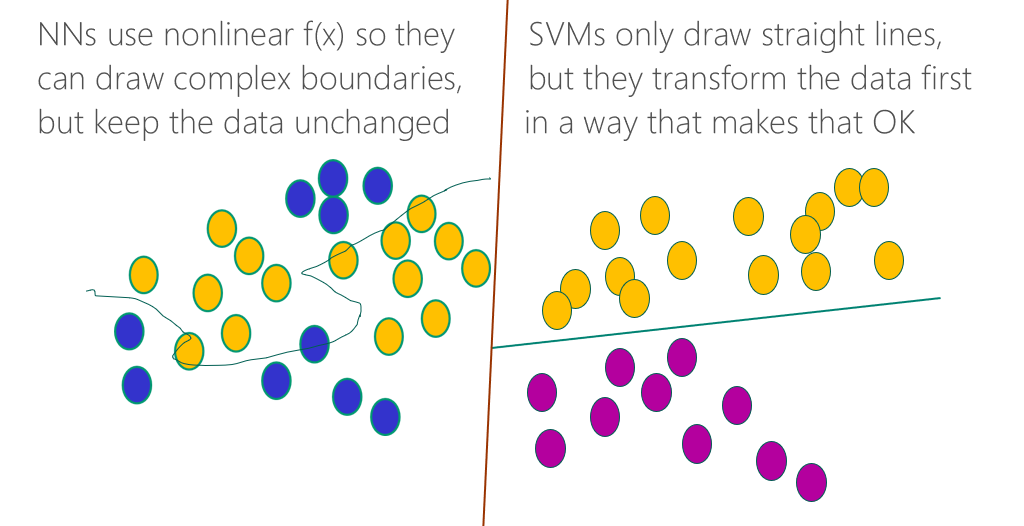

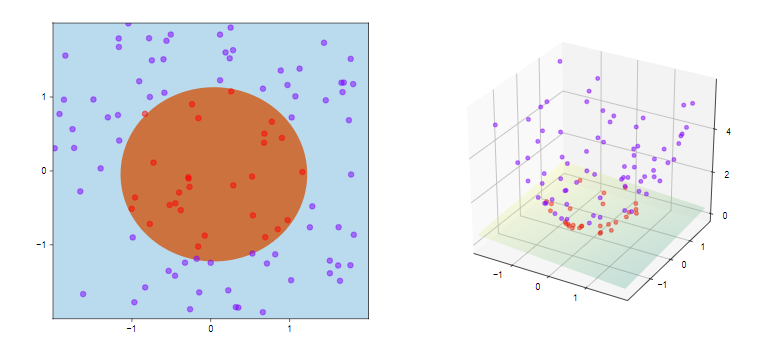

accuracy training data = 1.0

accuracy testing data = 0.5

results: ['1' '4' '2' '2' '5' '5' '1' '2' '5' '5']



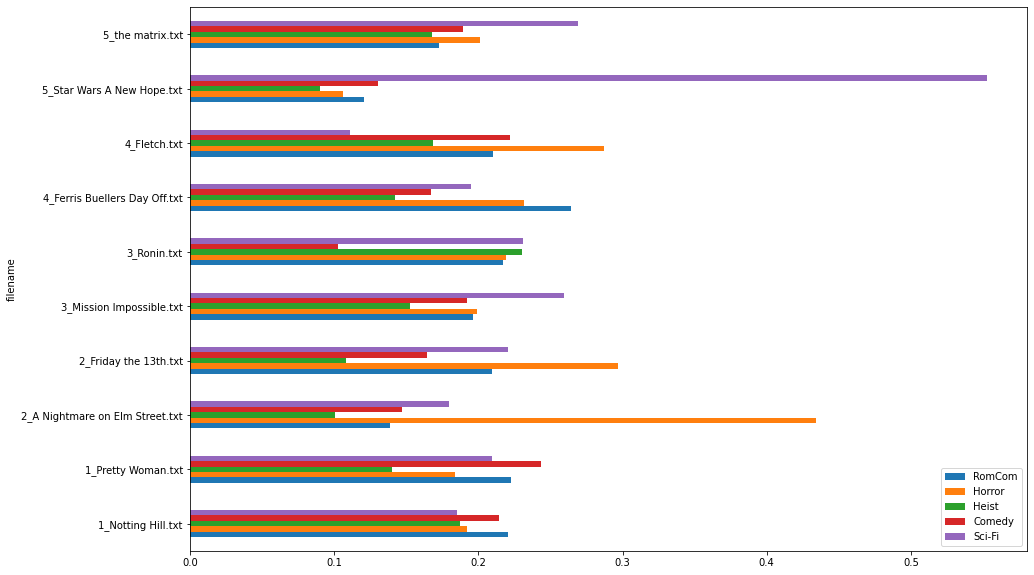

CPU times: user 8.93 s, sys: 134 ms, total: 9.07 s
Wall time: 17 s


,RomCom,Horror,Heist,Comedy,Sci-Fi,filename
0,0.220623,0.192392,0.187501,0.214354,0.185130,1_Notting Hill.txt
1,0.222658,0.184043,0.140185,0.243421,0.209693,1_Pretty Woman.txt
2,0.138463,0.433989,0.100506,0.147367,0.179675,2_A Nightmare on Elm Street.txt
3,0.209727,0.296639,0.108225,0.164603,0.220807,2_Friday the 13th.txt
4,0.196336,0.199437,0.152420,0.192091,0.259716,3_Mission Impossible.txt
5,0.216992,0.219412,0.230006,0.102795,0.230795,3_Ronin.txt
6,0.264402,0.231793,0.141964,0.167056,0.194786,4_Ferris Buellers Day Off.txt
7,0.210271,0.287501,0.168801,0.222136,0.111291,4_Fletch.txt
8,0.120453,0.106468,0.090007,0.130382,0.552690,5_Star Wars A New Hope.txt
9,0.172489,0.201320,0.167974,0.189361,0.268857,5_the matrix.txt


In [39]:
%%time
#SVM

experiment = Experiment(workspace=ws, name=experiment_name)
run = experiment.start_logging(snapshot_directory=None)

run.tag("Description","SVM with stop words")

from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                      ('tfidf', TfidfTransformer()),
                      #('clf-svm', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42)
                     ('clf-svm', SGDClassifier(loss='log', penalty='l2', alpha=1e-3, random_state=42)
                      )])

text_clf = text_clf.fit(dfscript['Text'], dfscript['Label'])

predicted = text_clf.predict(dfscript['Text'])

print('accuracy training data = ' + str(np.mean(text_clf.predict(dfscript['Text']) == dfscript['Label'])))
run.log('accuracy training data', np.mean(text_clf.predict(dfscript['Text']) == dfscript['Label']))
print('\r')
print('accuracy testing data = ' + str(np.mean(text_clf.predict(dfscriptTesting['Text']) == dfscriptTesting['Label'])))
run.log('accuracy testing data', np.mean(text_clf.predict(dfscriptTesting['Text']) == dfscriptTesting['Label']))
print('\r')
print('results: ' + str(text_clf.predict(dfscriptTesting['Text'])))
run.log('results', text_clf.predict(dfscriptTesting['Text']))
print('\r')
dfres = pd.DataFrame(text_clf.predict_proba(dfscriptTesting['Text'])).rename(columns = {0:'RomCom', 1:'Horror', 2:"Heist" , 3: "Comedy", 4: "Sci-Fi"})
dfres['filename'] = dfscriptTesting['filename']

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
dfres.plot.barh(x='filename',figsize=(15,10), sort_columns=True)
run.log_image("results graph", path=None, plot=plt)
plt.show()

run.complete()

pd.DataFrame(dfres)


## Don't run this as a demo! Takes 4mins

In [17]:
%%time
#GridSearchCV - Exhaustive search over specified parameter values for an estimator.

from sklearn.model_selection import GridSearchCV
#parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1e-2, 1e-3)}

parameters = {'clf__alpha': (0.01, 0.001, 0.005, 0.0001, 0.00001, 1, 10),
              'clf__loss': ['log'],
             'clf__penalty': ['elasticnet', 'l2'],
             'clf__l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1]}

#NBclassifier
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                      ('tfidf', TfidfTransformer()),
                      #('clf-svm', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42)
                     ('clf', SGDClassifier(random_state=42)
                      )])

text_clf = text_clf.fit(dfscript['Text'], dfscript['Label'])

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(dfscript['Text'], dfscript['Label'])

print(gs_clf.best_score_)
print(gs_clf.best_params_)

0.5462962962962963
{'clf__alpha': 1e-05, 'clf__l1_ratio': 0.05, 'clf__loss': 'log', 'clf__penalty': 'elasticnet'}
CPU times: user 16.4 s, sys: 10.9 s, total: 27.4 s
Wall time: 3min 37s


accuracy training data = 1.0

accuracy testing data = 0.5

results: ['4' '4' '2' '2' '5' '3' '1' '2' '5' '5']



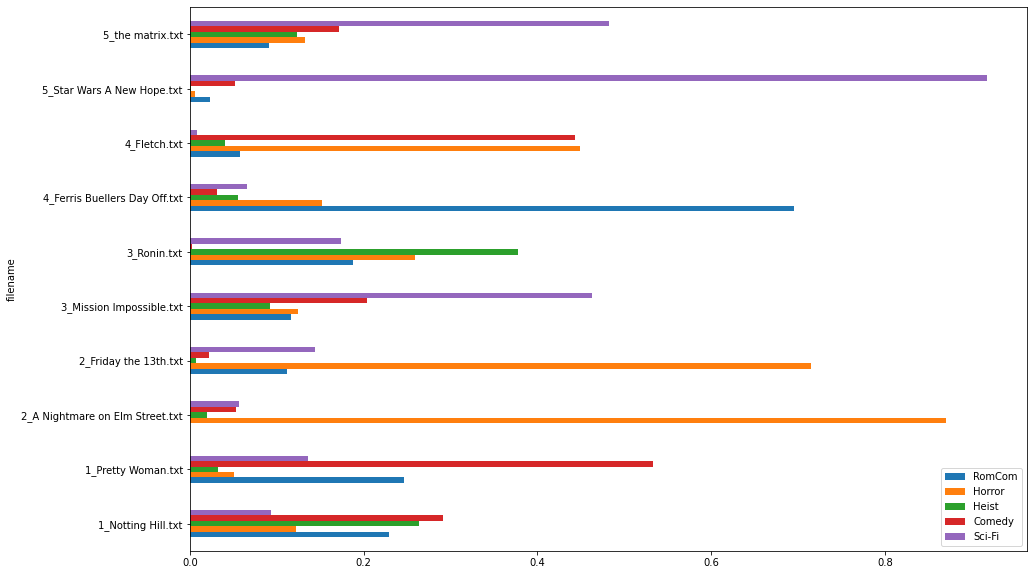

CPU times: user 9.35 s, sys: 163 ms, total: 9.51 s
Wall time: 17.2 s


,RomCom,Horror,Heist,Comedy,Sci-Fi,filename
0,0.228959,0.122187,0.263807,0.291044,0.094004,1_Notting Hill.txt
1,0.246629,0.051332,0.032885,0.533284,0.135870,1_Pretty Woman.txt
2,0.000158,0.870061,0.019582,0.053219,0.056980,2_A Nightmare on Elm Street.txt
3,0.111319,0.715614,0.007481,0.021685,0.143901,2_Friday the 13th.txt
4,0.116262,0.124989,0.091957,0.203666,0.463126,3_Mission Impossible.txt
5,0.187643,0.258661,0.377909,0.002015,0.173772,3_Ronin.txt
6,0.695354,0.152098,0.055216,0.031012,0.066321,4_Ferris Buellers Day Off.txt
7,0.057977,0.449506,0.040152,0.443872,0.008493,4_Fletch.txt
8,0.023294,0.006123,0.001418,0.051528,0.917636,5_Star Wars A New Hope.txt
9,0.091233,0.132063,0.122835,0.171148,0.482721,5_the matrix.txt


In [40]:
%%time
#SVM with the new hyperparameters

experiment = Experiment(workspace=ws, name=experiment_name)
run = experiment.start_logging(snapshot_directory=None)

run.tag("Description","MLPClassifier with stop words and hyperparameters")

from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                      ('tfidf', TfidfTransformer()),
                      #('clf-svm', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42)
                     ('clf-svm', SGDClassifier(alpha= 1e-05, l1_ratio= 0.05, loss= 'log', penalty= 'elasticnet')
                      )])

text_clf = text_clf.fit(dfscript['Text'], dfscript['Label'])

predicted = text_clf.predict(dfscript['Text'])

print('accuracy training data = ' + str(np.mean(text_clf.predict(dfscript['Text']) == dfscript['Label'])))
run.log('accuracy training data', np.mean(text_clf.predict(dfscript['Text']) == dfscript['Label']))
print('\r')
print('accuracy testing data = ' + str(np.mean(text_clf.predict(dfscriptTesting['Text']) == dfscriptTesting['Label'])))
run.log('accuracy testing data', np.mean(text_clf.predict(dfscriptTesting['Text']) == dfscriptTesting['Label']))
print('\r')
print('results: ' + str(text_clf.predict(dfscriptTesting['Text'])))
run.log('results', text_clf.predict(dfscriptTesting['Text']))
print('\r')
dfres = pd.DataFrame(text_clf.predict_proba(dfscriptTesting['Text'])).rename(columns = {0:'RomCom', 1:'Horror', 2:"Heist" , 3: "Comedy", 4: "Sci-Fi"})
dfres['filename'] = dfscriptTesting['filename']

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
dfres.plot.barh(x='filename',figsize=(15,10), sort_columns=True)
run.log_image("results graph", path=None, plot=plt)
plt.show()

run.complete()

pd.DataFrame(dfres)


In [41]:
#Export to ONNX
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType, FloatTensorType

model_onnx = convert_sklearn(text_clf, "test_input",
                                     initial_types=[("Text_input", StringTensorType([1, 1]))])

with open("model.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

The maximum opset needed by this model is only 10.
The maximum opset needed by this model is only 1.
The maximum opset needed by this model is only 1.


## AutoML

<p>Automl uses A text featurizer  <br>
Each word's embedding vector in a document is aggregated with the rest to produce a document feature vector.</p>

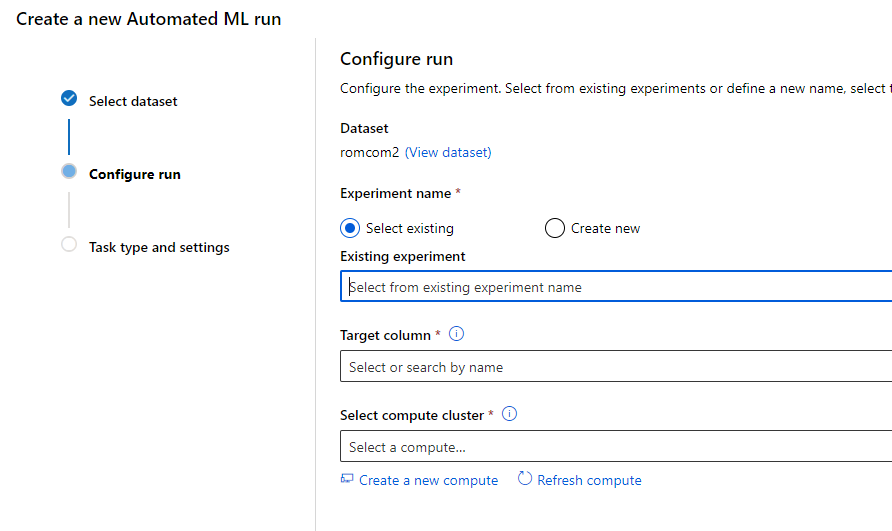

In [42]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget

# choose a name for your cluster
AmlCompute_cluster_name = "automlcluster"
cluster_min_nodes = 0
cluster_max_nodes = 20
vm_size = "Standard_D4_v3"
autoscale_enabled = True


if AmlCompute_cluster_name in ws.compute_targets:
    compute_target = ws.compute_targets[AmlCompute_cluster_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + AmlCompute_cluster_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = cluster_min_nodes, 
                                                                max_nodes = cluster_max_nodes,
                                                                idle_seconds_before_scaledown=120)
    
    # create the cluster
    compute_target = ComputeTarget.create(ws, AmlCompute_cluster_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current BatchAI cluster status, use the 'status' property    
    print(compute_target.status.serialize())



found compute target. just use it. automlcluster


In [21]:
#Load the data into a datastore so the cluster can pick it up later
project_folder = './project'

if not os.path.isdir('datascript'):
    os.mkdir('datascript')
    
if not os.path.exists(project_folder):
    os.makedirs(project_folder)

#Get rid of tabs so we can turn into a csv
dfscript["Text"] = dfscript["Text"].replace('\n','  ', regex=True)
dfscript["Text"] = dfscript["Text"].replace('^',' ', regex=True)
    
pd.DataFrame(dfscript[["Label", "Text"]]).to_csv("datascript/trainscript.csv", sep='^', index=False)

ds = ws.get_default_datastore()
ds.upload(src_dir='./datascript', target_path='storesdatascript', overwrite=True, show_progress=True)

Uploading an estimated of 1 files
Uploading ./datascript/trainscript.csv
Uploaded ./datascript/trainscript.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_9cd8d4a3842e41afa45d721da78a0056

In [22]:
#Get the pointers to the data
datastore = ws.get_default_datastore()
from azureml.core import Dataset
X = Dataset.Tabular.from_delimited_files(path = [(datastore, 'storesdatascript/trainscript.csv')],separator='^')


In [23]:
from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.runconfig import DEFAULT_CPU_IMAGE

# create a new runconfig object
run_config = RunConfiguration()

run_config.target = compute_target

# enable Docker 
run_config.environment.docker.enabled = True

# set Docker base image to the default CPU-based image
run_config.environment.docker.base_image = DEFAULT_CPU_IMAGE

# use conda_dependencies.yml to create a conda environment in the Docker image for execution
run_config.environment.python.user_managed_dependencies = False

conda = CondaDependencies.create(
#    pip_packages=['azureml-defaults', 'azureml-dataprep[fuse,pandas]', 'azureml-sdk'],
    pip_packages=['azureml-defaults', 'azureml-sdk'],
    pin_sdk_version=True
)

run_config.environment.python.conda_dependencies = conda

In [24]:
from azureml.train.automl import AutoMLConfig

settings = {
    "debug_log": 'automl_romcom.txt'
}


AutoML_config = AutoMLConfig(task = 'classification',
                            primary_metric = 'accuracy',
                            enable_dnn=True,
                            run_configuration=run_config,
                            iterations = 20,
                            path = project_folder,
                            #n_cross_validations=4,
                            enable_voting_ensemble = False,
                            enable_stack_ensemble = False,
                            training_data = X,
                            label_column_name = "Label",
                            #blacklist_models = ['model list'],
                            max_concurrent_iterations = 20,
                            **settings
                        )


In [25]:
#Run the automl
from azureml.core.experiment import Experiment
experiment=Experiment(ws, 'romcomautoml1')
run = experiment.submit(AutoML_config)

Running on remote.


In [26]:
#View the results in a widget
from azureml.widgets import RunDetails
RunDetails(run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

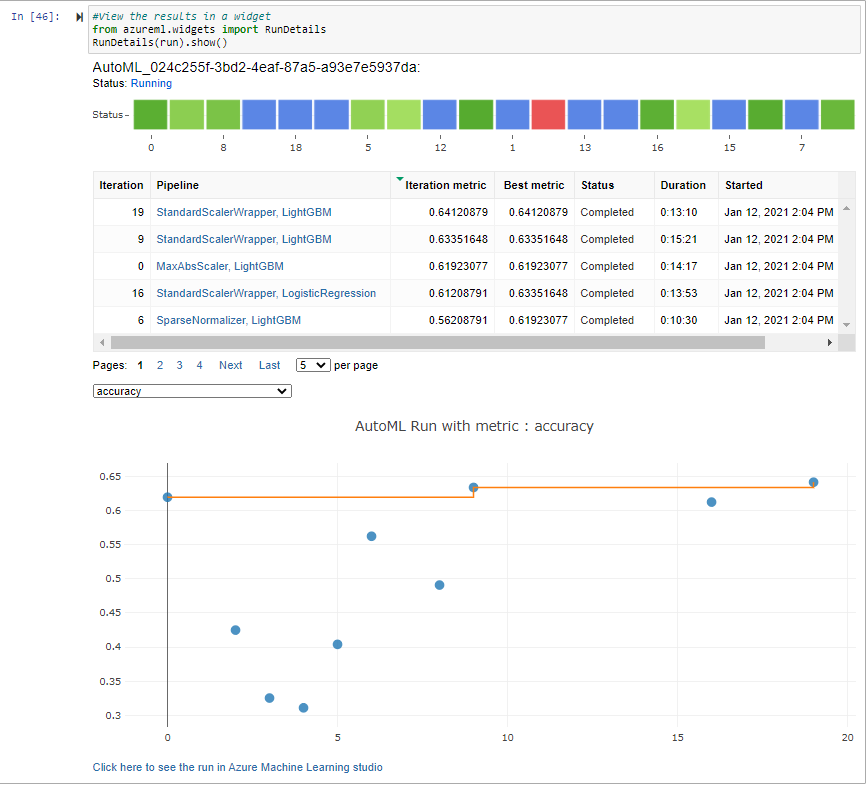

### Get the best experiment form autoML

In [43]:
for e in Experiment.list(ws):
        if e.name == "romcom2automl":
            expr = e
print(expr)

Experiment(Name: romcom2automl,
Workspace: MLServiceWrokspace)


In [44]:
%%time
#Get the best model
from tqdm import tqdm
runs = {}
run_metrics = {}
runsorder = {}
i=0

for r in expr.get_runs():
    metrics = r.get_metrics()
    for s in tqdm(r.get_children()):
        #print(s.name)
        metrics = s.get_metrics()
        if 'accuracy' in metrics.keys():
            i=i+1
            runs[s.id] = s
            run_metrics[s.id] = metrics
            

46it [00:27,  1.65it/s]

CPU times: user 1.8 s, sys: 203 ms, total: 2 s
Wall time: 29.5 s


In [45]:
best_run_id = max(run_metrics, key = lambda k : run_metrics[k]['accuracy'])

pd.DataFrame(pd.Series(run_metrics[best_run_id]), columns=['Value'])

,Value
f1_score_weighted,0.897436
recall_score_micro,0.923077
average_precision_score_micro,0.989744
f1_score_micro,0.923077
matthews_correlation,0.889946
average_precision_score_macro,1
precision_score_micro,0.923077
AUC_macro,1
precision_score_macro,0.7
f1_score_macro,0.733333


In [46]:
#Get the model filename
bestrun = runs[best_run_id]
#bestrun.get_file_names()
for f in bestrun.get_file_names():
    if(f[-4:] == '.pkl'):
        modelfilename = f
print(modelfilename)

outputs/model.pkl


In [47]:
modelload = bestrun.register_model(model_name='model', model_path=modelfilename)
modelload.download(exist_ok = True)

'model.pkl'

In [48]:
#Load the model
import pickle
import azureml
import azureml.train.automl
model = pickle.load(open('model.pkl', 'rb'))
os.remove('model.pkl')

accuracy testing data = 0.7


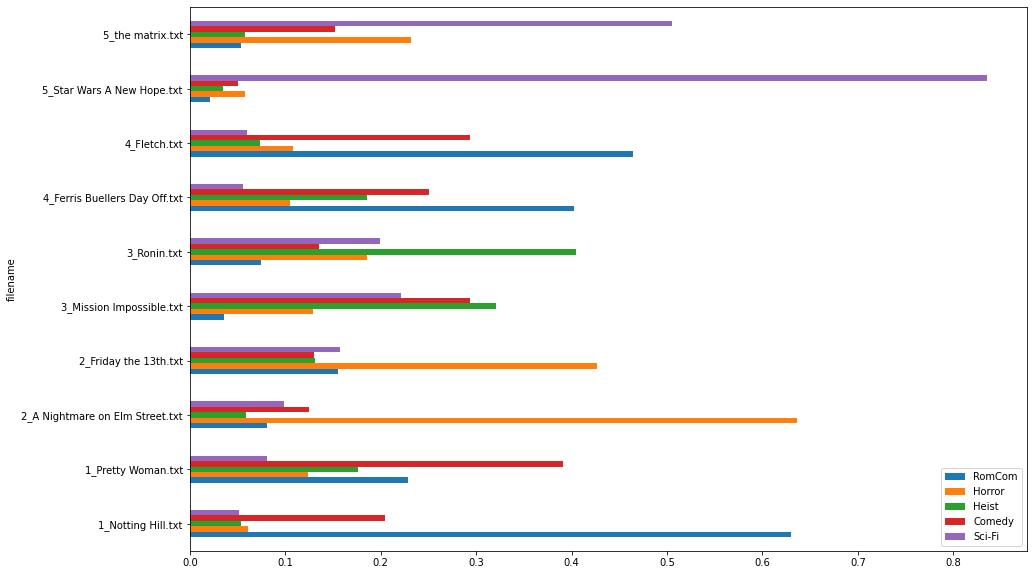

,RomCom,Horror,Heist,Comedy,Sci-Fi,filename
0,0.63,0.06,0.05,0.20,0.05,1_Notting Hill.txt
1,0.23,0.12,0.18,0.39,0.08,1_Pretty Woman.txt
2,0.08,0.64,0.06,0.13,0.10,2_A Nightmare on Elm Street.txt
3,0.15,0.43,0.13,0.13,0.16,2_Friday the 13th.txt
4,0.04,0.13,0.32,0.29,0.22,3_Mission Impossible.txt
5,0.07,0.19,0.40,0.14,0.20,3_Ronin.txt
6,0.40,0.11,0.19,0.25,0.06,4_Ferris Buellers Day Off.txt
7,0.46,0.11,0.07,0.29,0.06,4_Fletch.txt
8,0.02,0.06,0.03,0.05,0.84,5_Star Wars A New Hope.txt
9,0.05,0.23,0.06,0.15,0.50,5_the matrix.txt


In [49]:
df = pd.DataFrame()
df["Text"] = dfscriptTesting["Text"]
type(pd.DataFrame(df))
df.columns
predicted = model.predict_proba(X = df)

print('accuracy testing data = ' + str(np.mean(model.predict(X = df) == dfscriptTesting['Label'].to_numpy(dtype=int))))

dfres = pd.DataFrame(pd.DataFrame(predicted).rename(columns = {0:'RomCom', 1:'Horror', 2:"Heist" , 3: "Comedy", 4: "Sci-Fi"}))
dfres['filename'] = dfscriptTesting['filename']

dfres.plot.barh(x='filename',figsize=(15,10), sort_columns=True)
run.log_image("results graph", path=None, plot=plt)
plt.show()

pd.DataFrame(dfres)

## Use a DNN to classify

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Activation, LSTM, Embedding, Bidirectional
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import Adam


Using TensorFlow backend.


In [65]:
#!pip install nltk
#import nltk
#nltk.download('punkt')
#nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
#Remove stopwords and create a tfidf
# Import stopwords with nltk.
from nltk.corpus import stopwords
stop = stopwords.words('english')

x_train = pd.DataFrame()

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
x_train['Text'] = dfscript['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#print(test)

num_labels = 5
vocab_size = 15000
batch_size = 100
 
# define Tokenizer with Vocab Size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(dfscript['Text'])
 
x_train = tokenizer.texts_to_matrix(x_train['Text'], mode='tfidf')
x_test = tokenizer.texts_to_matrix(dfscriptTesting['Text'], mode='tfidf')
 
encoder = LabelBinarizer()
encoder.fit(dfscript['Label'])
y_train = encoder.transform(dfscript['Label'])
y_test =  encoder.transform(dfscriptTesting['Label'])

In [13]:
from numpy.random import seed
np.random.seed(723970371)

model = Sequential()
model.add(Dense(1024, input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              15361024  
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
activation_2 (Activation)    (None, 1024)             

In [44]:
#! pip install pydot
#! pip install pydotplus
#! pip install graphviz
#! sudo apt install python-pydot python-pydot-ng graphviz 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.38.0-12ubuntu2.1).
The following packages were automatically installed and are no longer required:
  clamav clamav-base clamav-freshclam cmake-data grub-pc-bin libarchive13
  libclamav9 libjsoncpp1 libllvm3.6v5
Use 'sudo apt autoremove' to remove them.
The following NEW packages will be installed:
  python-pydot python-pydot-ng python-pyparsing
0 upgraded, 3 newly installed, 0 to remove and 86 not upgraded.
Need to get 76.1 kB of archives.
After this operation, 374 kB of additional disk space will be used.
Get:1 http://azure.archive.ubuntu.com/ubuntu xenial-updates/main amd64 python-pyparsing all 2.0.3+dfsg1-1ubuntu0.2 [35.4 kB]
Get:2 http://azure.archive.ubuntu.com/ubuntu xenial/universe amd64 python-pydot all 1.0.28-2 [21.1 kB]
Get:3 http://azure.archive.ubuntu.com/ubuntu xenial/universe amd64 python-pydot-ng all 1.0.0-2 [19.6 kB]
Fetched 76.1 kB i

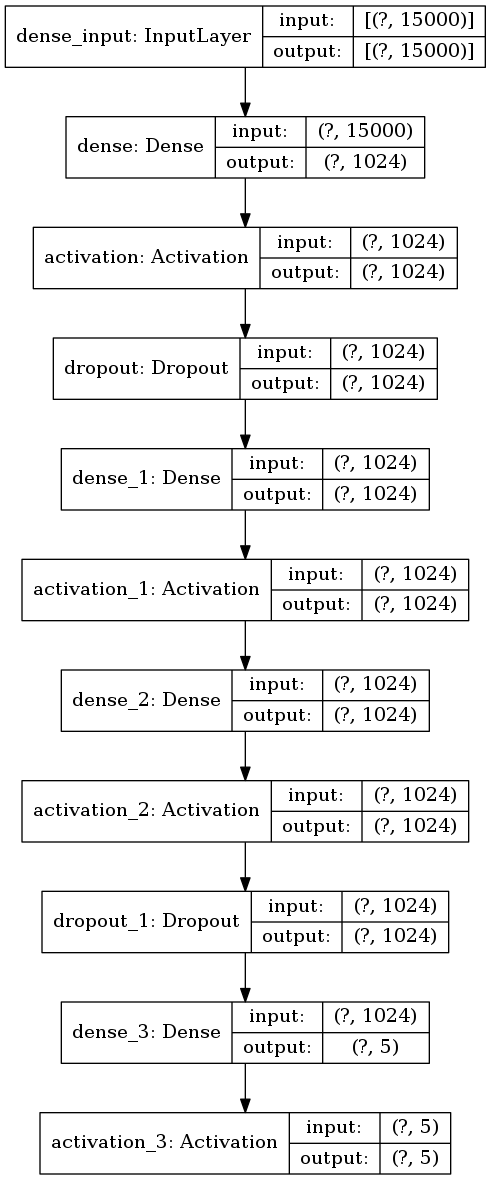

In [16]:
from tensorflow.keras.utils import plot_model
#from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, expand_nested=True)
#plot_model(model, to_file='model.png')

In [17]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=20,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/20
2/2 [==============================] - 0s 105ms/step - loss: 5.5614 - accuracy: 0.1680 - val_loss: 23.2643 - val_accuracy: 0.0000e+00
Epoch 2/20
2/2 [==============================] - 0s 22ms/step - loss: 15.1339 - accuracy: 0.2400 - val_loss: 0.4311 - val_accuracy: 0.9286
Epoch 3/20
2/2 [==============================] - 0s 20ms/step - loss: 3.5580 - accuracy: 0.3680 - val_loss: 5.6057 - val_accuracy: 0.0000e+00
Epoch 4/20
2/2 [==============================] - 0s 20ms/step - loss: 2.2600 - accuracy: 0.3840 - val_loss: 1.9303 - val_accuracy: 0.3571
Epoch 5/20
2/2 [==============================] - 0s 20ms/step - loss: 0.7404 - accuracy: 0.6800 - val_loss: 1.1231 - val_accuracy: 0.5000
Epoch 6/20
2/2 [==============================] - 0s 20ms/step - loss: 0.6735 - accuracy: 0.7280 - val_loss: 0.5369 - val_accuracy: 0.7143
Epoch 7/20
2/2 [==============================] - 0s 20ms/step - loss: 0.3009 - accuracy: 0.8800 - val_loss: 1.1148 - val_accuracy: 0.5714
Epoch 8/20
2/2 [

Instructions for updating:
Please use `model.predict()` instead.


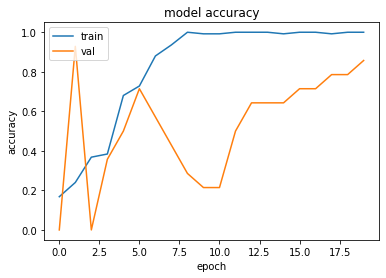

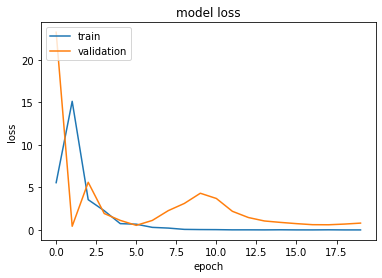

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
accuracy testing data = 0.6


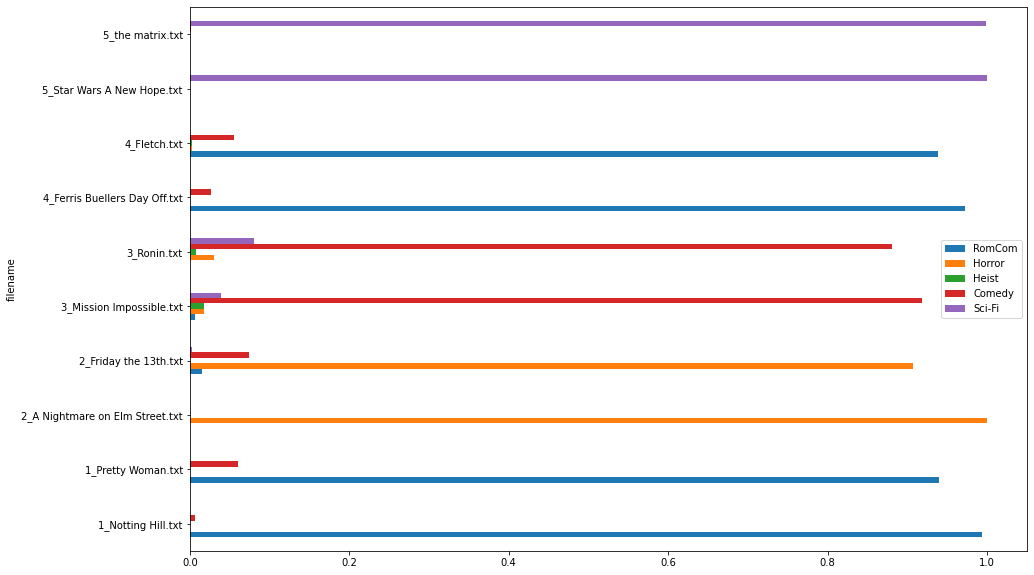

,RomCom,Horror,Heist,Comedy,Sci-Fi,filename
0,0.99375,0.00016,0.00001,0.00608,0.00001,1_Notting Hill.txt
1,0.93968,0.00005,0.00000,0.06027,0.00000,1_Pretty Woman.txt
2,0.00000,1.00000,0.00000,0.00000,0.00000,2_A Nightmare on Elm Street.txt
3,0.01524,0.90771,0.00066,0.07374,0.00264,2_Friday the 13th.txt
4,0.00657,0.01801,0.01839,0.91826,0.03876,3_Mission Impossible.txt
5,0.00055,0.02995,0.00793,0.88096,0.08061,3_Ronin.txt
6,0.97237,0.00037,0.00014,0.02712,0.00000,4_Ferris Buellers Day Off.txt
7,0.93884,0.00302,0.00311,0.05495,0.00007,4_Fletch.txt
8,0.00000,0.00000,0.00000,0.00000,1.00000,5_Star Wars A New Hope.txt
9,0.00000,0.00017,0.00002,0.00102,0.99879,5_the matrix.txt


In [18]:
#prediction = model.predict(np.array([x_test]))
prediction = model.predict_proba([x_test])
dfres = pd.DataFrame(prediction).rename(columns = {0:'RomCom', 1:'Horror', 2:"Heist" , 3: "Comedy", 4: "Sci-Fi"})
#dfres = pd.DataFrame(prediction[0]).rename(columns = {0:'RomCom', 1:'Horror', 2:"Heist" , 3: "Comedy", 4: "Sci-Fi"})
dfres['filename'] = dfscriptTesting['filename']

from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


#predictionlabels = model.predict_classes(np.array([x_test]))
predictionlabels = model.predict_classes([x_test])
#print('accuracy testing data = ' + str(np.mean((predictionlabels+1)[0] == dfscriptTesting['Label'].to_numpy(dtype=int))))
print('accuracy testing data = ' + str(np.mean((predictionlabels+1) == dfscriptTesting['Label'].to_numpy(dtype=int))))

dfres.plot.barh(x='filename',figsize=(15,10), sort_columns=True)
#run.log_image("results graph", path=None, plot=plt)
plt.show()

pd.DataFrame(dfres).round(5)


### <b>Reduce the learning rate
### Add more layers
### More epochs
### Use real validation data</b>

In [19]:
from numpy.random import seed
np.random.seed(723970371)

model = Sequential()
model.add(Dense(1024, input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()


optimizer = Adam(lr=0.00001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              15361024  
_________________________________________________________________
activation_4 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
activation_5 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
activation_6 (Activation)    (None, 1024)             

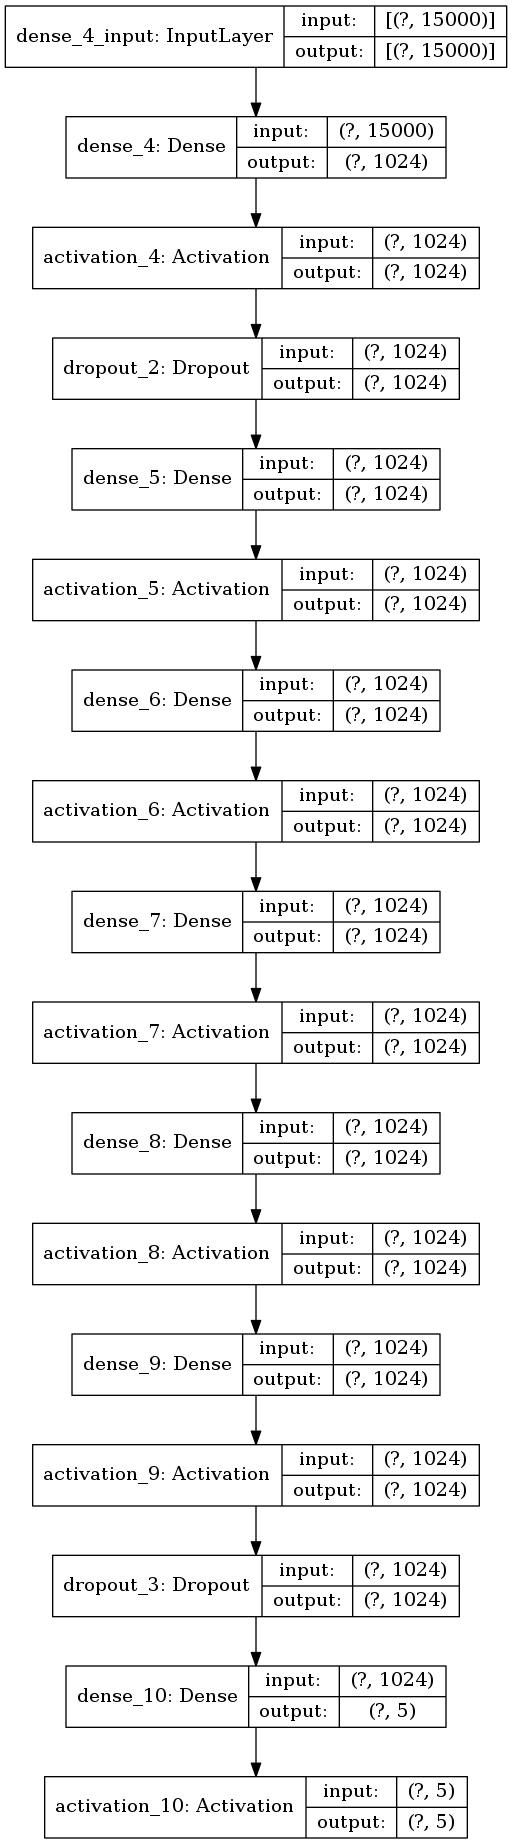

In [21]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png',  show_shapes=True, show_layer_names=True, expand_nested=True)

In [22]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=400,
                    verbose=0,
                    validation_data=(x_test, y_test))

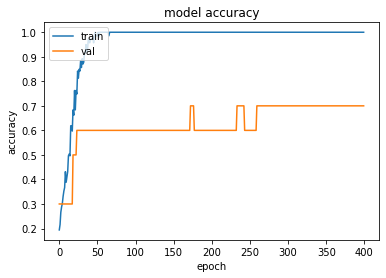

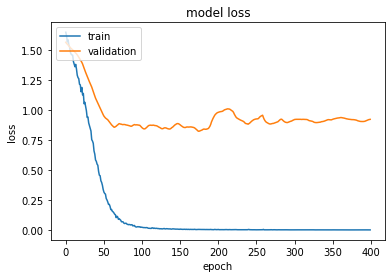

accuracy testing data = 0.7


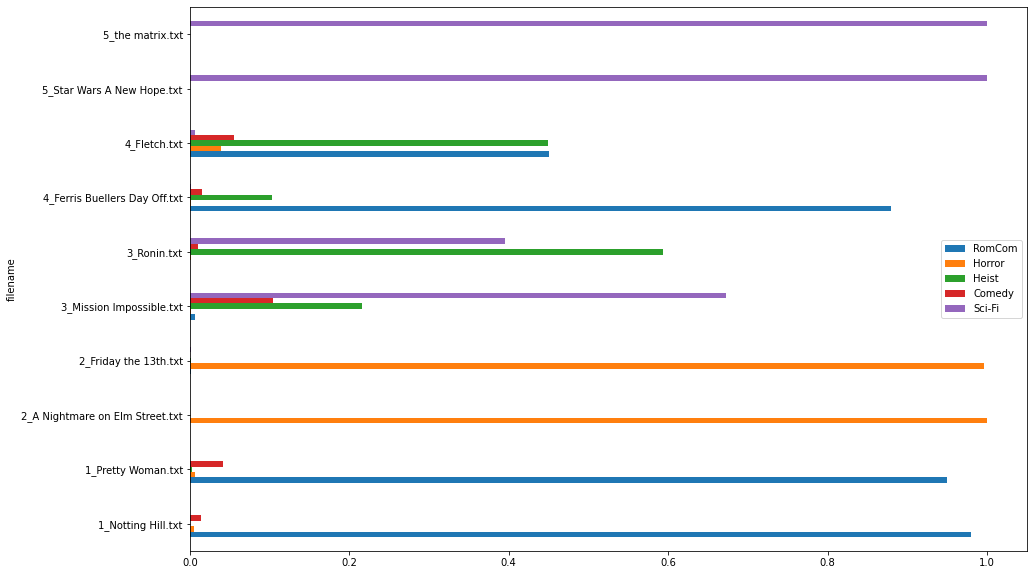

,RomCom,Horror,Heist,Comedy,Sci-Fi,filename
0,0.97961,0.00502,0.00044,0.01465,0.00027,1_Notting Hill.txt
1,0.94990,0.00590,0.00217,0.04190,0.00014,1_Pretty Woman.txt
2,0.00000,0.99992,0.00000,0.00000,0.00007,2_A Nightmare on Elm Street.txt
3,0.00135,0.99598,0.00096,0.00081,0.00090,2_Friday the 13th.txt
4,0.00627,0.00133,0.21609,0.10392,0.67239,3_Mission Impossible.txt
5,0.00010,0.00123,0.59398,0.00978,0.39492,3_Ronin.txt
6,0.87942,0.00111,0.10287,0.01515,0.00145,4_Ferris Buellers Day Off.txt
7,0.45082,0.03933,0.44873,0.05511,0.00600,4_Fletch.txt
8,0.00000,0.00000,0.00000,0.00000,1.00000,5_Star Wars A New Hope.txt
9,0.00001,0.00002,0.00005,0.00000,0.99992,5_the matrix.txt


In [23]:
#prediction = model.predict(np.array([x_test]))
prediction = model.predict_proba([x_test])
dfres = pd.DataFrame(prediction).rename(columns = {0:'RomCom', 1:'Horror', 2:"Heist" , 3: "Comedy", 4: "Sci-Fi"})
#dfres = pd.DataFrame(prediction[0]).rename(columns = {0:'RomCom', 1:'Horror', 2:"Heist" , 3: "Comedy", 4: "Sci-Fi"})
dfres['filename'] = dfscriptTesting['filename']

from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


#predictionlabels = model.predict_classes(np.array([x_test]))
predictionlabels = model.predict_classes([x_test])
#print('accuracy testing data = ' + str(np.mean((predictionlabels+1)[0] == dfscriptTesting['Label'].to_numpy(dtype=int))))
print('accuracy testing data = ' + str(np.mean((predictionlabels+1) == dfscriptTesting['Label'].to_numpy(dtype=int))))

dfres.plot.barh(x='filename',figsize=(15,10), sort_columns=True)
#run.log_image("results graph", path=None, plot=plt)
plt.show()

pd.DataFrame(dfres).round(5)


In [64]:
#import os
#import sys
#os.environ['TF_KERAS'] = '1'
#from importlib import reload
#keras2onnx = reload(keras2onnx)
    


In [17]:
#Convert to ONNX
import os
os.environ['TF_KERAS'] = '1'
import keras2onnx
import onnx

print(model.name)
#onnx_model = keras2onnx.convert_keras(model, model.name)
onnx_model = keras2onnx.convert_keras(model, "romcom")
onnx.save_model(onnx_model, "romcom.onnx")


sequential_1


The maximum opset needed by this model is only 9.
